# Lab 2: Deep Networks
## Goal of this lab:
1. How to build custom datasets and perpare data for training with dataloaders
2. How to build and train a neural network
3. Automatic differentiation with `autograd`

## Datasets and Dataloaders
PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples. Today, we focus on creating a custom dataset. 

### Datasets
In a custom Dataset class, we must implement three functions: `__init__`, `__len__`, and `__getitem__`. Here is a sample dataset class:
```python
class RegressionDataset(torch.utils.data.Dataset):    
    def __init__(self, x, y):
        super().__init__() 
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
```

#### 1. `__init__`
The `__init__` function is run once when instantiating the Dataset object. Here, we pass the input (`x`) and the label (`y`) and initialize them. 

#### 2. `__len__`
The `__len__` function returns the number of samples in our dataset.

#### 3. `__getitem__`
The `__getitem__` function loads and returns a sample from the dataset at the given index `idx`. Here, we return the `x` and `y` at index `idx`. 

Now, let's create a dummy dataset and implement a `Dataset` for it. 

In [1]:
import torch
import numpy as np
from sklearn.datasets import make_regression

# here, we use scikit-learn's make_regression function to create a dummy datasets with 32 features as input and a number as target
data_x, data_y = make_regression(n_samples = 1000, n_features = 32, random_state=0)
data_x = data_x.astype(np.float32)
data_y = data_y.astype(np.float32)

In [2]:
# implement the dataset here: 
class RegressionDataset(torch.utils.data.Dataset):    
    def __init__(self, x, y):
        super().__init__() 
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [3]:
train_dataset = RegressionDataset(data_x, data_y)

### Dataloaders
The `Dataset` retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s `multiprocessing` to speed up data retrieval.

`DataLoader` is an iterable that abstracts this complexity for us in an easy API.

In [4]:
from torch.utils.data import DataLoader

# create a dataloader with a batch size of 64, and set shuffling to true. 
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [5]:
# test to see if it works
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 32])
Labels batch shape: torch.Size([64])


## Build the neural network

The `torch.nn` namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the `nn.Module`. A neural network is a module itself that consists of other modules (layers). 

We define our neural network by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the `forward` method.

In [6]:
class RegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Linear == Dense == Fully Connected
        self.fc1 = torch.nn.Linear(in_features=32, out_features=1)
    
    def forward(self, x):
        return self.fc1(x)

In [7]:
model = RegressionModel()
print(model)

RegressionModel(
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)


### Train the neural network

Now that we have our dataset and model setup, it is time to train out model by optimizing the parameters on our data. Training a model is an iterative process; in each iteration the model makes a guess about the output, calculates the error in its guess (loss), collects the derivatives of the error with respect to its parameters, and optimizes these parameters using gradient descent. 

#### Hyperparameters

Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates (read more about hyperparameter tuning)

We define the following hyperparameters for training:
* **Number of Epochs:** the number times to iterate over the dataset
* **Batch Size:** the number of data samples propagated through the network before the parameters are updated
* **Learning Rate:** how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [8]:
# set up hyperparameters:
EPOCHS = 100
BATCH_SIZE = 64
LR = 1e-3

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Loss function (Criterion)
When presented with some training data, our untrained network is likely not to give the correct answer. Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value. 

Since we're doing a regression task, we will use mean squared error as our loss function

In [10]:
criterion = torch.nn.MSELoss()

#### Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. Here we use Stochastic Gradient Descent (SGD). 

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr = LR)

#### Training Loop
Inside the training loop, once the model prediction is made, optimization happens in three steps:
* Call `optimizer.zero_grad()` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
* Backpropagate the prediction loss with a call to `criterion.backward()`. PyTorch deposits the gradients of the loss w.r.t. each parameter.
* Once we have our gradients, we call `optimizer.step()` to adjust the parameters by the gradients collected in the backward pass.

Let's implement the loop below:

In [12]:
from tqdm.notebook import trange

training_loss = []
for epoch in trange(EPOCHS): # for each EPOCH
    for (x,y) in train_dataloader: # for each BATCH
        y_pred = model(x) # make prediction
        
        loss = criterion(y_pred.squeeze(),y) # calculate loss
        
        optimizer.zero_grad() # reset gradient
        loss.backward() # backpropagate
        optimizer.step() # update the weights
        
        training_loss.append(loss.item()) # save loss

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
# visualize the loss function
import matplotlib.pyplot as plt

def plot_loss(loss):
    x = np.arange(len(loss))
    plt.figure(dpi=150)
    plt.plot(x, loss)
    plt.xlabel('Step/Epoch')
    plt.ylabel('Training Loss')
    plt.show()

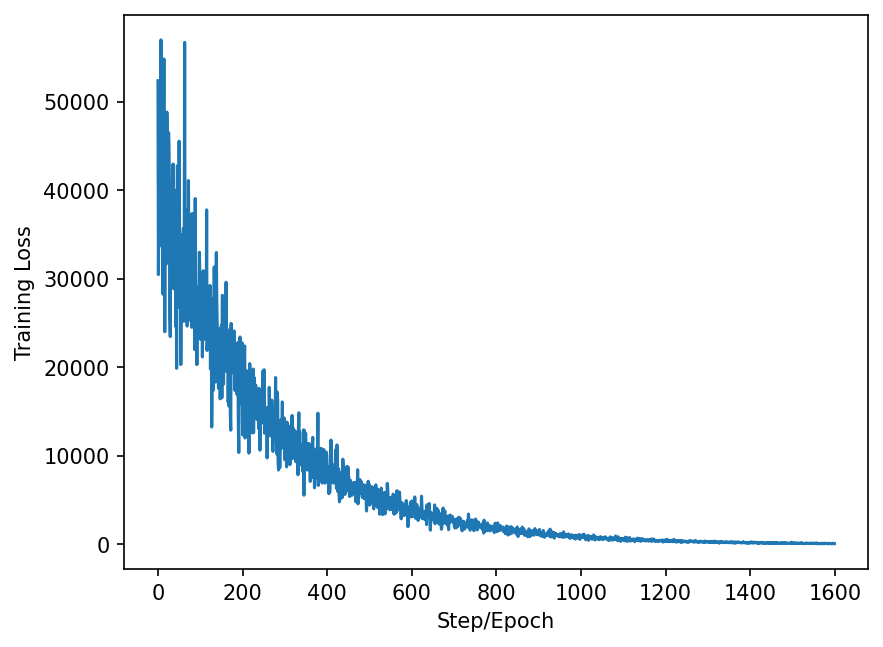

In [14]:
plot_loss(training_loss)

### Automatic Differentiation with `torch.autograd`

When training neural networks, the most frequently used algorithm is **back propagation**. In this algorithm, parameters (model weights) are adjusted according to the **gradient** of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called `torch.autograd`. It supports automatic computation of gradient for any computational graph.

Consider the simplest one-layer neural network, with input `x`, parameters `w` and `b`, and some loss function. It can be defined in PyTorch in the following manner:

In [15]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In this network, `w` and `b` are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. In order to do that, we set the `requires_grad` property of those tensors. Note: this property can also be set later using `x.requires_grad_(True)`

In [16]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x311d383d0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x314ed2c40>


#### Compute the graident

To optimize weights of parameters in the neural network, we need to compute the derivatives of our loss function with respect to parameters, namely, we need $\frac{d loss}{dw}$​ and $\frac{d loss}{db}$ under some fixed values of $x$ and $y$. To compute those derivatives, we call `loss.backward()`, and then retrieve the values from `w.grad` and `b.grad`:



In [17]:
# compute the gradient
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1687, 0.2428, 0.0062],
        [0.1687, 0.2428, 0.0062],
        [0.1687, 0.2428, 0.0062],
        [0.1687, 0.2428, 0.0062],
        [0.1687, 0.2428, 0.0062]])
tensor([0.1687, 0.2428, 0.0062])


#### Disabling Gradient Tracking
By default, all tensors with `requires_grad=True` are tracking their computational history and support gradient computation. However, there are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network. We can stop tracking computations by surrounding our computation code with `torch.no_grad()` block:

In [18]:
# disable gradient tracking
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


#### Implement the above neural network with `torch.autograd`

In [19]:
# recreate the linear layer above
w = torch.randn(32, requires_grad=True)
b = torch.randn(1, requires_grad=True)

In [20]:
training_loss_manual = []
for epoch in trange(EPOCHS): # for each EPOCH
    for (x,y) in train_dataloader: # for each BATCH
        y_pred = torch.matmul(x, w) + b
        loss = torch.mean(torch.square(y_pred - y)) # calculate loss

        # reset gradient
        w.grad = None
        b.grad = None
        
        # backpropagate
        loss.backward()
        
        # update the weights
        with torch.no_grad():
            w -= LR * w.grad
            b -= LR * b.grad
            
        training_loss_manual.append(loss.item()) # save loss 

  0%|          | 0/100 [00:00<?, ?it/s]

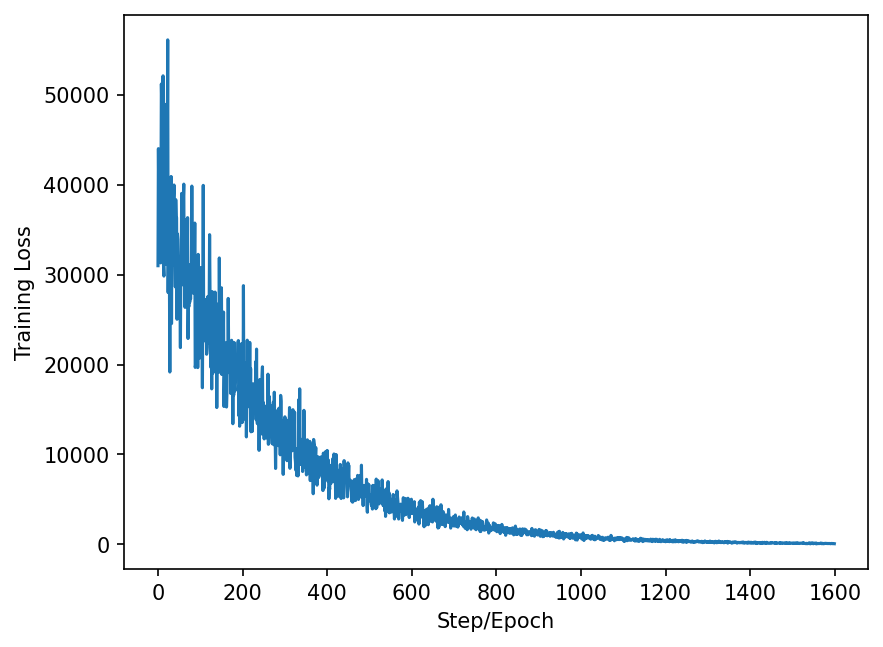

In [21]:
plot_loss(training_loss_manual)

#### Reference: 
Datasets and Dataloaders: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html  
Build the Neural Network: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html  
Automatic Differentiation with `torch.autograd`: https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
